<a href="https://colab.research.google.com/github/naynikaw/HumanActionRecognition/blob/main/I3D_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
import os
import numpy
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Loading the data
raw_data = load_files(os.getcwd() + r'/drive/MyDrive/videos', shuffle=False)
files = raw_data['filenames']
targets = raw_data['target']

In [6]:
# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [ ]:
sample_video = load_video(files[8])

In [ ]:
sample_video.shape

(211, 224, 224, 3)

In [7]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [8]:
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print(labels)
print("Found %d labels." % len(labels))

['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'checking tires', 'che

In [9]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [11]:
conversation_vid = load_video("/content/conversation.avi")
running_vid = load_video("/content/person15_running_d1_uncomp.avi")
walking_vid = load_video("/content/person15_walking_d1_uncomp.avi")
marching_vid1 = load_video("/content/v_BandMarching_g01_c01.avi")
marching_vid2 = load_video("/content/v_MilitaryParade_g03_c03.avi")

In [18]:
predict(conversation_vid)

Top 5 actions:
  playing badminton     : 38.64%
  catching or throwing baseball: 18.21%
  dodgeball             :  9.26%
  passing American football (not in game):  4.90%
  catching or throwing frisbee:  4.50%


In [14]:
predict(running_vid)

Top 5 actions:
  snowkiting            : 10.55%
  jogging               :  8.11%
  passing American football (not in game):  4.48%
  diving cliff          :  4.15%
  playing bagpipes      :  3.37%


In [15]:
predict(walking_vid)

Top 5 actions:
  ice skating           : 13.29%
  cartwheeling          :  4.68%
  tai chi               :  4.36%
  bungee jumping        :  3.76%
  diving cliff          :  3.18%


In [16]:
predict(marching_vid1)

Top 5 actions:
  marching              : 100.00%
  country line dancing  :  0.00%
  playing trumpet       :  0.00%
  playing trombone      :  0.00%
  shaking hands         :  0.00%


In [17]:
predict(marching_vid2)

Top 5 actions:
  marching              : 40.81%
  shredding paper       :  5.58%
  ice skating           :  3.02%
  cleaning pool         :  2.81%
  sled dog racing       :  2.16%


In [ ]:
!pip install pytube

     |████████████████████████████████| 56 kB 2.7 MB/s 


In [ ]:
from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=5d7VvQcWscY").streams.first().download()

In [ ]:
slap_video_path="Will Smith slaps Chris Rock at the Oscars after joke at wife Jada Pinkett Smiths expense  ABC7.3gpp"

In [ ]:
sample_video = load_video(slap_video_path)[120:220]
sample_video.shape

(100, 224, 224, 3)


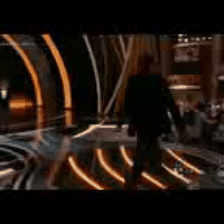

In [ ]:
to_gif(sample_video)

In [ ]:
predict(sample_video)

Top 5 actions:
  parkour               : 16.41%
  skateboarding         :  7.51%
  jumpstyle dancing     :  4.25%
  dunking basketball    :  4.20%
  moving furniture      :  4.04%
